<a href="https://colab.research.google.com/github/MahdiEsrafili/image_segmentation/blob/master/face_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/MahdiEsrafili/SegLoss.git

Cloning into 'SegLoss'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 371.26 KiB | 1.15 MiB/s, done.
Resolving deltas: 100% (157/157), done.


In [3]:
#dataset from https://data.mendeley.com/datasets/sv7ns5xv7f/1
!wget https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/sv7ns5xv7f-1.zip

--2021-02-17 16:22:10--  https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/sv7ns5xv7f-1.zip
Resolving md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)... 52.218.41.72
Connecting to md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com (md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com)|52.218.41.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 208481896 (199M) [application/octet-stream]
Saving to: ‘sv7ns5xv7f-1.zip’

sv7ns5xv7f-1.zip    100%[===================>] 198.82M  56.7MB/s    in 3.5s    

2021-02-17 16:22:13 (56.7 MB/s) - ‘sv7ns5xv7f-1.zip’ saved [208481896/208481896]



In [6]:
!unzip -q sv7ns5xv7f-1.zip -d data/
!unzip -q /content/data/FASSEG-DB-v2019/Fasseg-DB-v2019.zip -d /content/data/data/

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import numpy as np
import os
import random
from PIL import Image
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

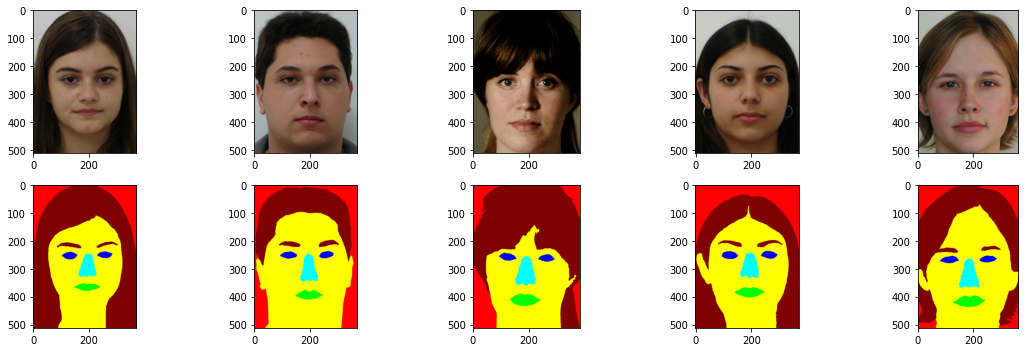

In [117]:
path = '/content/data/data/FASSEG-frontal02'
ids = random.sample(range(21), 5)
plt.figure(figsize=(16,5))
for i, id in enumerate(ids):
  img = Image.open(os.path.join(path, 'Train_RGB', f'{id}.bmp'))
  mask = Image.open(os.path.join(path, 'Train_Labels', f'{id}.bmp'))
  plt.subplot(2, 5, i+1)
  plt.imshow(img)
  plt.subplot(2, 5, 5+i+1)
  plt.imshow(mask)

plt.tight_layout()

## masks are created for segmenting 6 parts of face, but they are in 3 channels with multiple values. in this part I create a quantizer for generating a one-channel mask for each

In [186]:
from sklearn.cluster import KMeans
class MaskQuantizer:
  def __init__(self, num_classes = 6):
    self.num_classes = num_classes

  def train(self, mask):
    x = np.array(mask).reshape((-1, 3))
    self.km = KMeans(n_clusters=self.num_classes)
    self.km.fit(x)

  def quantize(self, mask):
    mask_r = np.array(mask).reshape((-1, 3))
    quantized_r = km.predict(mask_r)
    quantized = quantized_r.reshape(np.array(mask).shape[:2])
    return quantized

In [187]:
quantizer = MaskQuantizer()
quantizer.train(mask)

In [188]:
import warnings
warnings.filterwarnings("ignore")

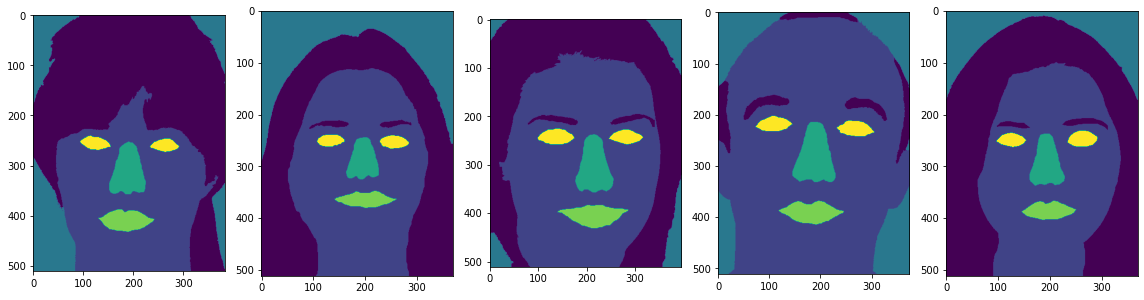

In [189]:
plt.figure(figsize=(16,5))
for i in range(5):
  masks = os.listdir(os.path.join(path, 'Train_Labels'))
  masks = random.sample(masks, 5)
  for i, m in enumerate(masks):
    m = os.path.join(path, 'Train_Labels', m)
    m = Image.open(m)
    m = quantizer.quantize(m)
    plt.subplot(1,5,i+1)
    plt.imshow(m)

plt.tight_layout()

In [131]:
np.unique(m)

array([0, 1, 2, 3, 4, 5], dtype=int32)

In [136]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms as T
from torchvision import models
from tqdm.notebook import tqdm
import torchvision
import torch

In [177]:
class FaceDS(Dataset):
  def __init__(self, path, transforms=None, train=True):
    self.path = path
    self.transforms = transforms
    self.train = train

  def __len__(self):
    return len(os.listdir(os.path.join(self.path, 'Train_RGB' if self.train else 'Test_RGB')))
  
  def __getitem__(self, idx):
    img_path = os.path.join(self.path, 'Train_RGB' if self.train else 'Test_RGB', f'{idx+1}.bmp')
    mask_path = os.path.join(self.path, 'Train_Labels' if self.train else 'Test_Labels', f'{idx+1}.bmp')
    img = Image.open(img_path)
    mask = Image.open(mask_path)
    mask = quantizer.quantize(mask)
    if self.transforms:
      img = self.transforms(img)
      mask = self.transforms(mask)
    return img, mask

In [178]:
transforms = T.Compose([
                        T.Resize((480, 480)),
                        T.ToTensor()                        
])

In [179]:
path = '/content/data/data/FASSEG-frontal02'
train_dataset = FaceDS(path, transforms)
test_dataset = FaceDS(path, transforms, train=False)

batch_size = 4
train_loader = DataLoader(train_dataset, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [174]:
len(test_dataset)

50

In [161]:
model = models.segmentation.deeplabv3_resnet50(pretrained=True, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


In [163]:
model.classifier = models.segmentation.deeplabv3.DeepLabHead(2048, 6)

In [164]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [165]:
model = model.train().to(device)

In [166]:
def train(model, optimizer, criterion, lr_scheduler, dataloaders, num_epochs=10):
  model.train()
  loss_history = list()
  num_epochs=10
  for epoch in range(num_epochs):
    pbar = tqdm(dataloaders['train'])
    epoch_losses = np.array([])
    for (images, masks) in pbar:
      images = images.to(device, dtype=torch.float)
      masks = masks.to(device, dtype=torch.long).view(-1, masks.size(2), masks.size(3))
      optimizer.zero_grad()
      out = model(images)
      loss = criterion(out['out'], masks)
      loss.backward()
      optimizer.step()
      epoch_losses = np.append(epoch_losses, loss.item())
      pbar.set_description(f'epoch {epoch+1}/{num_epochs},\
                            loss= {epoch_losses.mean():.4f}')
    loss_history.append(epoch_losses.mean())
    lr_scheduler.step()
  return loss_history
      

In [167]:
from SegLoss.losses_pytorch import lovasz_loss


In [168]:
lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
# criterion = torch.nn.CrossEntropyLoss()
criterion = lovasz_loss.LovaszSoftmax()
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

In [180]:
dataloaders = {'train': train_loader,
               'test': test_loader}

In [181]:
train(model, optimizer, criterion, lr_scheduler, dataloaders)

TypeError: ignored

In [ ]:
with open('/content/model.pt', 'wb') as f:
  torch.save(model,f)

!cp /content/model.pt /content/drive/MyDrive/bacterial_segmentation/

In [ ]:
!cp /content/drive/MyDrive/bacterial_segmentation/model.pt /content/
model = torch.load('/content/model.pt')

In [ ]:
def test(model, dataloaders, criterion):
  with torch.no_grad():
    results = []
    ground_truth = []
    losses = np.array([])
    model.eval()
    for (images, masks) in dataloaders['test']:
      images = images.to(device)
      masks = masks.to(device)
      preds = model(images)
      results.append(preds['out'].cpu())
      loss = criterion(preds['out'], masks)
      losses = np.append(losses, loss.item())
    return results, losses

In [ ]:
results, losses = test(model, dataloaders, criterion)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


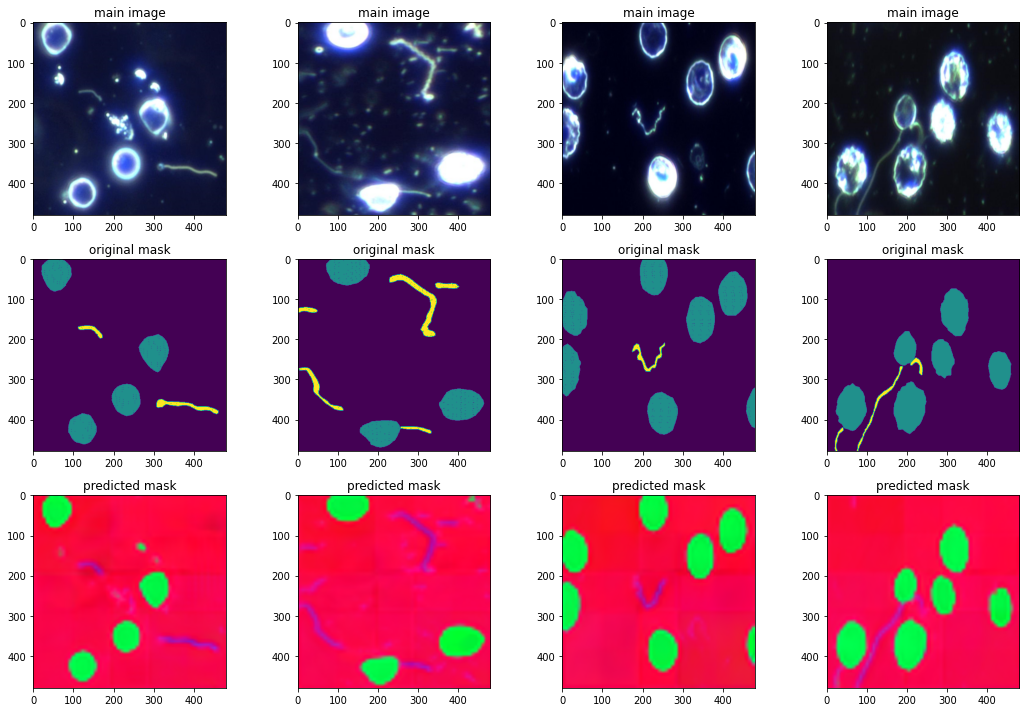

In [ ]:
plt.figure(figsize=(15, 10))
test_img = iter(test_loader)
for batches in results:
  grounds = next(test_img)
  for i, pred in enumerate(batches):
    plt.subplot(3, 4, i+1)
    plt.title('main image')
    plt.imshow(grounds[0][i].permute(1,2,0))
    plt.subplot(3, 4, 4+i+1)
    plt.title('original mask')
    plt.imshow(grounds[1][i][0])
    plt.subplot(3, 4, 8+i+1)
    plt.title('predicted mask')
    plt.imshow(pred.permute(1,2,0))
  break

plt.tight_layout()

In [ ]:
losses

array([0.23681298, 0.25595269, 0.25099736, 0.24305168, 0.25354725,
       0.26385069, 0.25541493, 0.26013345, 0.24195519, 0.25560242,
       0.26267967, 0.25223443, 0.31354114, 0.25597849, 0.24941549,
       0.24256782, 0.26660046, 0.24529806, 0.26145881, 0.26787645,
       0.25267899, 0.26229432, 0.25404975, 0.28607225, 0.24037664,
       0.25405937, 0.23452988, 0.6582936 ])